# Tilt notation
![Notation](tiltNotation.png)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from pystackreg import StackReg
from matplotlib.colors import hsv_to_rgb
from scipy.ndimage import zoom
from pathlib import Path
import h5py

%matplotlib widget

class UnifiedDict:
    def __init__(self, source):
        self._source = source

    def __getitem__(self, key):
        item = self._source[key]
        if isinstance(item, (dict, h5py.Group)):
            return UnifiedDict(item)
        elif isinstance(item, h5py.Dataset):
            return np.array(item)
        elif hasattr(item, 'numpy'):
            return item.numpy()
        else:
            return item

def load_stack_from_pt(pt_path):
    if pt_path.endswith('.pt'):
        data = UnifiedDict(torch.load(pt_path, map_location=torch.device('cpu')))
    elif pt_path.endswith('.hdf5'):
        data = UnifiedDict(h5py.File(pt_path, 'r'))
        
    crop_pos = data['model_attributes']['crop_pos'] + np.array(data['optimizable_tensors']['probe'].shape[-2:]) // 2
    ys, xs = np.min(crop_pos, axis=0)
    ye, xe = np.max(crop_pos, axis=0)

    objP = np.squeeze(data['optimizable_tensors']['objp'])[:, ys-1:ye, xs-1:xe]
    dx = data['model_attributes']['dx'].item()
    dz = data['model_attributes']['slice_thickness'].item()
    tiltRef = np.squeeze(data['optimizable_tensors']['obj_tilts'])

    return objP, dx, dz, tiltRef


def compute_patch_shifts(img):
    """
    Compute 2D shifts to align each slice in a 3D patch stack to the previous slice using pystackreg.

    Parameters
    ----------
    img : np.ndarray
        3D array of cropped patch with shape (Z, H, W).

    Returns
    -------
    shifts : np.ndarray
        Array of shape (Z, 2) of cumulative shifts [dx, dy] per slice w.r.t slice 0:
        - shifts[0] = [0, 0]
        - shifts[z, 0] is horizontal movement (minus means move right).
        - shifts[z, 1] is vertical movement (plus means move up).
    """
    # initialize StackReg for translation
    sr = StackReg(StackReg.TRANSLATION)
    # sr.register_stack returns transform matrices of shape (Z, 3, 3)
    transforms = sr.register_stack(img, reference='previous')
    # extract translation components from each 3x3 matrix
    # transforms[z,:2,2] gives [tx, ty] where positive tx moves image right, ty moves image down
    # we want dx = -tx (minus means move right), dy = -ty (plus means move up)
    Z = img.shape[0]
    shifts = transforms[:, :2, -1]
    return shifts


def compute_tilt_map(stack, dx, dz, kernel_size, output_shape):
    """
    tilt-map using cropped patches and pystackreg shifts.

    Parameters
    ----------
    stack : np.ndarray
        3D image stack of shape (Z, H, W).
    dx : float
        Pixel size in x/y (same units as dz).
    dz : float
        Slice spacing along Z (same units as dx).
    kernel_size : tuple of int
        (ky, kx) patch size.
    output_shape : tuple of int
        Number of patches in (ny, nx) directions.

    Returns
    -------
    tilt_x : np.ndarray
        Tilt angle along X for each patch (radians).
    tilt_y : np.ndarray
        Tilt angle along Y for each patch (radians).
    shifts_map : np.ndarray
        Per-patch per-slice shifts: shape (ny, nx, Z, 2).
    """
    Z, H, W = stack.shape
    ky, kx = kernel_size
    ny, nx = output_shape

    step_y = (H - ky) // (ny - 1) if ny > 1 else 0
    step_x = (W - kx) // (nx - 1) if nx > 1 else 0

    tilt_x = np.zeros((ny, nx), dtype=float)
    tilt_y = np.zeros((ny, nx), dtype=float)
    shifts_map = np.zeros((ny, nx, Z, 2), dtype=float)

    for i in tqdm(range(ny), desc='Rows'):
        for j in tqdm(range(nx), desc='Cols', leave=False):
            y0 = i * step_y
            x0 = j * step_x
            patch = stack[:, y0:y0+ky, x0:x0+kx]
            # compute cumulative shifts per slice
            shifts = compute_patch_shifts(patch)
            shifts_map[i, j] = shifts

            zpos = np.arange(0, Z)
            # horizontal shifts in shifts[:,0]
            slope_x = np.polyfit(zpos, shifts[:, 0], 1)[0]
            # vertical shifts in shifts[:,1]
            slope_y = np.polyfit(zpos, shifts[:, 1], 1)[0]

            tilt_x[i, j] = np.arctan((slope_x * dx) / dz)
            tilt_y[i, j] = np.arctan((slope_y * dx) / dz)

    # mrads
    tilt_x *= 1000
    tilt_y *= 1000
    return tilt_x, tilt_y, shifts_map


def visualize_tilt_map(tilt_x, tilt_y, extent=None, quiver_scale=1.0, prefix=''):
    """Display tilt maps and colored quiver."""
    ny, nx = tilt_x.shape
    fig, axes = plt.subplots(1,3,figsize=(10,3), sharex=True, sharey=True, constrained_layout=True)
    im0 = axes[1].imshow(tilt_x, extent=extent, vmax=np.max(abs(tilt_x)), vmin=-np.max(abs(tilt_x)), cmap='RdBu_r')
    fig.colorbar(im0, ax=axes[1], label='Tilt X (mrad)')
    axes[1].set_title(f'{prefix} Tilt X')
    im1 = axes[0].imshow(tilt_y, extent=extent, vmax=np.max(abs(tilt_y)), vmin=-np.max(abs(tilt_y)), cmap='RdBu_r')
    fig.colorbar(im1, ax=axes[0], label='Tilt Y (mrad)')
    axes[0].set_title(f'{prefix} Tilt Y')

    X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
    U, V = tilt_x, tilt_y
    mag = np.hypot(U, V)
    ang = (np.arctan2(V, U) + np.pi) / (2*np.pi)
    s = np.clip(mag/np.max(mag), 0,1)
    hsv = np.stack((ang, s, s), axis=-1)
    rgb = hsv_to_rgb(hsv)

    axes[2].imshow(rgb)

    step_x = max(1, nx // 16)
    step_y = max(1, ny // 16)

    X_ds = X[8::step_y, 8::step_x]
    Y_ds = Y[8::step_y, 8::step_x]
    U_ds = U[8::step_y, 8::step_x]
    V_ds = V[8::step_y, 8::step_x]
    u, v = 2, 2
    length = np.sqrt(u ** 2 + v ** 2)
    width = 0.005
    hal = hl = 1. / width * length
    axes[2].quiver(
        X_ds, Y_ds, U_ds, V_ds, color='white', scale=quiver_scale, angles='xy', units='inches',
        edgecolor=None, linewidth=0.8, pivot='mid', headaxislength=hal, headlength=hl, headwidth=hl / 3 * 2,  width=width)
    axes[2].set_title(f'{prefix} Tilt Field')
    axes[2].set_xlabel('Scan X index')
    axes[2].set_ylabel('Scan Y index')



def save_tilt(tilt_x, tilt_y, ref=[0, 0], fname='tiltMap', output_shape=None):
    """
    Subtract a reference from tilt maps, optionally interpolate to desired output shape,
    flatten, and save as an [N,2] numpy array.

    Parameters
    ----------
    tilt_x : np.ndarray
        2D array of tilt X values (ny, nx).
    tilt_y : np.ndarray
        2D array of tilt Y values (ny, nx).
    ref : np.ndarray or sequence of two arrays
        If 2D array same shape as tilt maps, interpreted as reference for both:
            tilt_y -= ref; tilt_x -= ref
        If sequence (ry, rx), each 2D: tilt_y -= ry; tilt_x -= rx
    fname : str
        Filepath to save the flattened [N,2] array via np.save.
    output_shape : tuple of int, optional
        Desired shape (ny_out, nx_out) to resize tilt maps before flattening (default = None).
    """
    # interpolate to output shape first if needed
    if output_shape is not None:
        zoom_factors = (output_shape[0] / tilt_y.shape[0], output_shape[1] / tilt_y.shape[1])
        tilt_y = zoom(tilt_y, zoom_factors, order=1)
        tilt_x = zoom(tilt_x, zoom_factors, order=1)

    # reference subtraction
    ry, rx = ref
    adj_y = tilt_y.ravel() + ry
    adj_x = tilt_x.ravel() + rx

    # flatten and stack into shape [N,2]
    data = np.stack((adj_y, adj_x), axis=1)

    # save
    np.save(fname, data)
    print(f"Saved tilt data of shape {data.shape} to '{fname}.npy'")
    return adj_x.reshape(output_shape), adj_y.reshape(output_shape), 


def compute_tilt_map_EMPAD():
    """
    TBD: esimate the titlmap from the COM for locally averaged PACBED?
    """
    pass

In [40]:
objP, dx, dz, tiltRef = load_stack_from_pt('/Users/menglin/Desktop/model_error_-1.03735_t0087_conv_angle_25.2_defocus_-250_Nlayer_8_iter0200.hdf5')
tilt_x, tilt_y, shifts_map = compute_tilt_map(objP[3:-2], dx, dz, (66, 66), (3, 3),)

Rows: 100%|██████████| 3/3 [00:00<00:00, 88.93it/s]


Saved tilt data of shape (65536, 2) to '/Users/menglin/Desktop/tiltMap.npy'
Average tx, ty fit: 1.142530572132483 -0.6000085474662397
Total ty, tx: 3.19 2.48


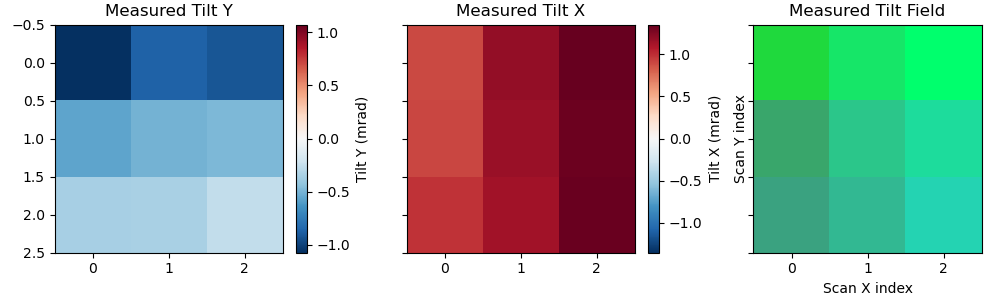

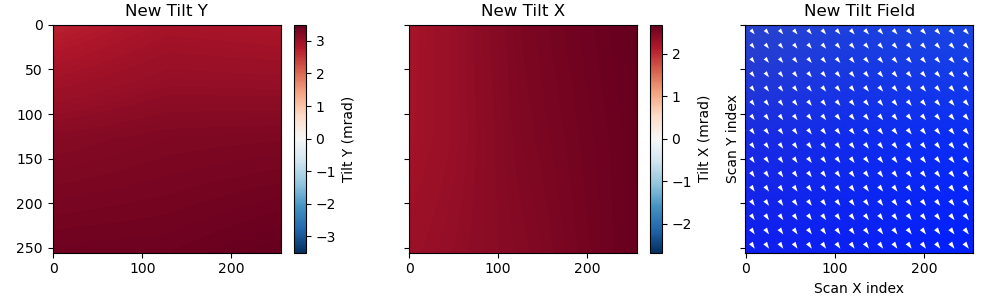

In [41]:
plt.close('all')
adj_tx, adj_ty = save_tilt(tilt_x, tilt_y, fname='/Users/menglin/Desktop/tiltMap', output_shape=[256,256], ref=tiltRef.T)
# o_ty, o_tx = tiltRef.T
# o_tx = o_tx.reshape(256, 256)
# o_ty = o_ty.reshape(256, 256)


# visualize_tilt_map(o_tx, o_ty, quiver_scale=np.mean(np.hypot(o_tx, o_ty))*15, prefix='Original')
visualize_tilt_map(tilt_x, tilt_y, quiver_scale=np.mean(np.hypot(tilt_x, tilt_y))*15, prefix='Measured')
visualize_tilt_map(adj_tx, adj_ty, quiver_scale=np.mean(np.hypot(adj_tx, adj_ty))*15, prefix='New')
print("Average tx, ty fit:", tilt_x.mean(), tilt_y.mean(),)
print("Total ty, tx:", round(adj_ty.mean(),2), round(adj_tx.mean(), 2),)